In [1]:
import os
import math
from ast import literal_eval
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from utils.preprocess_torchaudio import normalize_tensor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torch.nn.functional as F
from torchvision import transforms

# Set the device to gpu if possible else to cpu
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(DEVICE)
if torch.cuda.is_available():
    print('GPU : ', torch.cuda.get_device_name())

GPU :  NVIDIA GeForce GTX 1660 Ti


Loading Data

In [2]:
X = torch.load('../../data/mel_spec_wav_6.pt')
Y = torch.load('../../data/target_mel_spec_wav_6.pt')

normalized = True
X = normalize_tensor(X)

print(X.shape)
print(Y.shape)

sequence_length = X.shape[1]
input_size = X.shape[2]

torch.Size([20138, 128, 94])
torch.Size([20138, 6])


In [3]:
batch_size = 64

dataset = TensorDataset(X, Y)
train_size = int(len(Y) * 0.8)
test_size = len(Y) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
print(f'train set size : {len(train_dataset)}')
print(f'test set size : {len(test_dataset)}')

train set size : 16110
test set size : 4028


Teacher Model

In [4]:
# model parameters
num_layers = 4
hidden_size = 50
num_classes = 6
dropout = 0.25
lr = 0.003
num_epochs = 100

inner_linear_size = [2000,100]

class LSTM_t(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, sequence_length, dropout, inner_linear_size):
        super(LSTM_t, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.sequence_length = sequence_length
        self.dropout = dropout
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(p=0.15)
        self.fc1 = nn.Linear(hidden_size*sequence_length, inner_linear_size[0])
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(inner_linear_size[0], inner_linear_size[1])
        self.fc3 = nn.Linear(inner_linear_size[1], num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, (_,_) = self.lstm(x, (h0, c0))
        # out = self.fc(out[:, -1, :])
        out = out.reshape(out.shape[0], -1)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    
teacher = LSTM_t(input_size, hidden_size, num_layers, num_classes, sequence_length, dropout, inner_linear_size)
teacher.to(device)

teacher_num_params = sum(p.numel() for p in teacher.parameters() if p.requires_grad)
print('teacher parameters : ', teacher_num_params)

teacher parameters :  13093106


Loading teacher's weight

In [5]:
teacher.load_state_dict(torch.load("../models/lstm-V5.pth",map_location=device))

<All keys matched successfully>

Testing teacher model

In [6]:
teacher.eval()

nb_just = 0
nb = 0

for batch_idx, (data, target) in enumerate(test_loader):
    data = data.to(device)
    target = target.to(device)
    output = teacher(data)
    nb_just += torch.sum(torch.argmax(output,axis=1) == torch.argmax(target,axis=1))
    nb += output.shape[0]
    
    
acc = nb_just/nb    
print(f"Accuracy sur le test: {acc:.4f}")

Accuracy sur le test: 0.9930


Student Model

In [7]:
# model parameters
num_layers = 4
hidden_size = 50
num_classes = 6
dropout = 0.25
lr = 0.003
num_epochs = 100

class LSTM_s(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, sequence_length, dropout):
        super(LSTM_s, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.sequence_length = sequence_length
        self.dropout = dropout
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size*sequence_length, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, (_,_) = self.lstm(x, (h0, c0))
        # out = self.fc(out[:, -1, :])
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out
    
student = LSTM_s(input_size, hidden_size, num_layers, num_classes, sequence_length, dropout)
student.to(device)

student_num_params = sum(p.numel() for p in student.parameters() if p.requires_grad)
print('student parameters : ', student_num_params)

student parameters :  128806


Training

In [8]:
criterion = nn.MSELoss()
optimizer = optim.Adam(student.parameters(), lr=lr)


# np.nan si non utilisé
scheduler_milestone = [30, 55, 80]
scheduler_gamma = 1/3
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=scheduler_milestone, gamma=scheduler_gamma)

In [9]:
loss_trace_y = []
test_accuracy_trace_y = []

# Training loop
for epoch in range(num_epochs):
    teacher.train(False)
    student.train()
    loss_t = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        with torch.no_grad():
                output_teacher = teacher(data)
        output = student(data)     
        loss = criterion(output, output_teacher)
        loss.backward()
        optimizer.step()
        loss_t += loss.item()
        
    scheduler.step()

    epoch_loss = loss_t/(batch_idx+1)
    loss_trace_y.insert(epoch, epoch_loss)
    if epoch+1 == 1 or (epoch+1)%10 == 0:
        # \t lr: {scheduler.get_last_lr()[0]:.5f}
        print(f'Train Epoch: {epoch+1}/{num_epochs}\tLoss: {epoch_loss:.6f}\t lr: {scheduler.get_last_lr()[0]:.5f}')
        
    student.eval()

    nb_just = 0
    nb = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device)
        target = target.to(device)
        output = student(data)
        nb_just += torch.sum(torch.argmax(output,axis=1) == torch.argmax(target,axis=1))
        nb += output.shape[0]
    
    acc = nb_just/nb
    test_accuracy_trace_y.insert(epoch, acc.detach().cpu().numpy().item())
    if epoch+1 == 1 or (epoch+1)%10 == 0:
        print(f"Accuracy sur le test: {acc:.4f}")

Train Epoch: 1/100	Loss: 212.891089	 lr: 0.00300
Accuracy sur le test: 0.7167
Train Epoch: 10/100	Loss: 34.285928	 lr: 0.00300
Accuracy sur le test: 0.9094
Train Epoch: 20/100	Loss: 21.621750	 lr: 0.00300
Accuracy sur le test: 0.9283
Train Epoch: 30/100	Loss: 17.307270	 lr: 0.00100
Accuracy sur le test: 0.9402
Train Epoch: 40/100	Loss: 11.376583	 lr: 0.00100
Accuracy sur le test: 0.9464
Train Epoch: 50/100	Loss: 10.149492	 lr: 0.00100
Accuracy sur le test: 0.9476
Train Epoch: 60/100	Loss: 8.487152	 lr: 0.00033
Accuracy sur le test: 0.9496
Train Epoch: 70/100	Loss: 8.182542	 lr: 0.00033
Accuracy sur le test: 0.9486
Train Epoch: 80/100	Loss: 7.784416	 lr: 0.00011
Accuracy sur le test: 0.9523
Train Epoch: 90/100	Loss: 7.377319	 lr: 0.00011
Accuracy sur le test: 0.9499
Train Epoch: 100/100	Loss: 7.233952	 lr: 0.00011
Accuracy sur le test: 0.9513


In [11]:
# PATH =  './../models/lstm-student-V6.pth'
# torch.save(student.state_dict(), PATH)

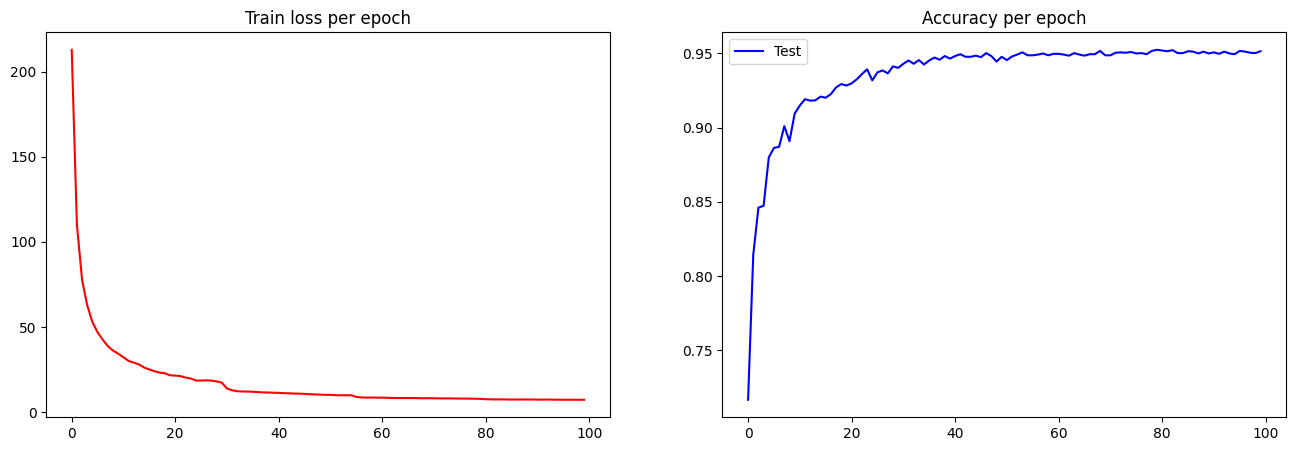

In [10]:
# Plot accuracy and loss graphs captured during the training process.
fig, ax = plt.subplots(1,2,figsize=(16, 5))
ax[0].set_title('Train loss per epoch')
ax[0].plot(loss_trace_y, color='red', label='Loss')

ax[1].set_title('Accuracy per epoch')
ax[1].plot(test_accuracy_trace_y, color='blue', label='Test')
plt.legend()

plt.show()

Reduction coef with distillation

In [18]:
print(f'reduction by {100 - teacher_num_params/(student_num_params*100):.2f} % of teacher size')

reduction by 98.98 % of teacher size
